In [55]:
import igl
import networkx as nx
import numpy as np
import meshplot as mp
import drawsvg as draw
import scipy.spatial.transform
import math

In [2]:
def is_adjacent (current_face, face):
    is_adjacent = False
    common_vertices = np.intersect1d(current_face, face)
    # if two or more vertices are shared the face is adjacent
    if len(common_vertices) >=2:
        is_adjacent = True
    return is_adjacent

def add_edges_from_mesh(graph, faces):
    for current_face_id, current_face in enumerate(faces):
        for face_id, face in enumerate(faces):
            if is_adjacent(current_face, face) and current_face_id != face_id:
                graph.add_edge(current_face_id,face_id)

# adds nodes to graph G for every face in mesh
def add_nodes_from_mesh(graph, faces): [graph.add_node(face_id) for face_id, face in enumerate(faces)]

# create networkx graph from given mesh
def graph_from_mesh(faces):
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces)
    return graph

  (0, 1)	1
  (0, 7)	1
  (0, 11)	1
  (1, 0)	1
  (1, 5)	1
  (1, 8)	1
  (2, 3)	1
  (2, 6)	1
  (2, 9)	1
  (3, 2)	1
  (3, 4)	1
  (3, 10)	1
  (4, 3)	1
  (4, 5)	1
  (4, 9)	1
  (5, 1)	1
  (5, 4)	1
  (5, 11)	1
  (6, 2)	1
  (6, 7)	1
  (6, 10)	1
  (7, 0)	1
  (7, 6)	1
  (7, 8)	1
  (8, 1)	1
  (8, 7)	1
  (8, 9)	1
  (9, 2)	1
  (9, 4)	1
  (9, 8)	1
  (10, 3)	1
  (10, 6)	1
  (10, 11)	1
  (11, 0)	1
  (11, 5)	1
  (11, 10)	1


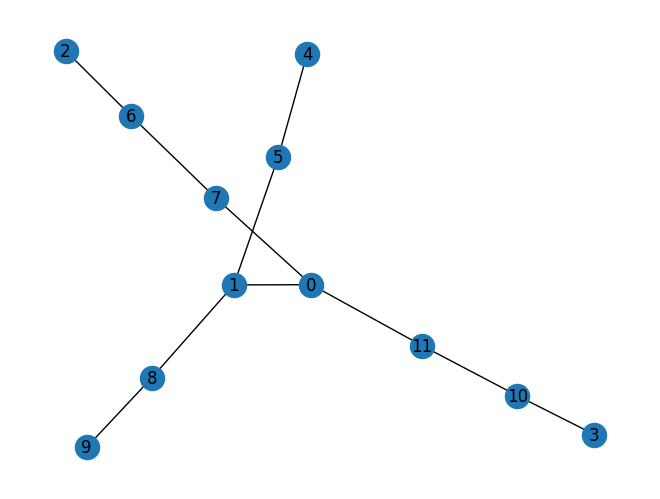

In [3]:
raw_vertices, raw_faces = igl.read_triangle_mesh("cube.stl")
vertices, faces = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)
graph = graph_from_mesh(faces)
spanning_tree = nx.minimum_spanning_tree(graph, algorithm='prim')
nx.draw(spanning_tree, with_labels = True)
print(nx.adjacency_matrix(graph))

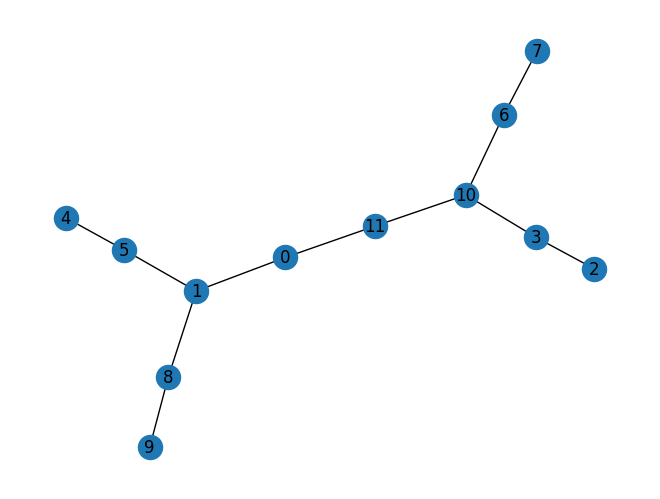

In [4]:
spanning_tree = nx.Graph()

spanning_tree.add_edge(4, 5)
spanning_tree.add_edge(5, 1)
spanning_tree.add_edge(9, 8)
spanning_tree.add_edge(8, 1)

spanning_tree.add_edge(1, 0)
spanning_tree.add_edge(0, 11)
spanning_tree.add_edge(11, 10)
spanning_tree.add_edge(10, 6)
spanning_tree.add_edge(10, 3)
spanning_tree.add_edge(3, 2)
spanning_tree.add_edge(6, 7)

nx.draw(spanning_tree, with_labels = True)

In [5]:
p = mp.plot(vertices, faces, c=np.random.rand(*faces.shape))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-5.0, 8.0…

[4, 5, 1, 9, 8, 0, 11, 10, 6, 3, 2, 7]
[(4, 1), (5, 2), (1, 3), (9, 1), (8, 2), (0, 2), (11, 2), (10, 3), (6, 2), (3, 2), (2, 1), (7, 1)]
[5, 1, 8, 0, 11, 10, 6, 3]
[(5, 1), (1, 3), (8, 1), (0, 2), (11, 2), (10, 3), (6, 1), (3, 1)]
[1, 0, 11, 10]
[(1, 1), (0, 2), (11, 2), (10, 1)]
[0, 11]
[(0, 1), (11, 1)]
[4. 3. 1. 2. 1. 2. 2. 1. 2. 1. 3. 4.]
[10, 2]
[4, 1]
[10, 7]
[9, 1]
[1, 11]
[0, 10]


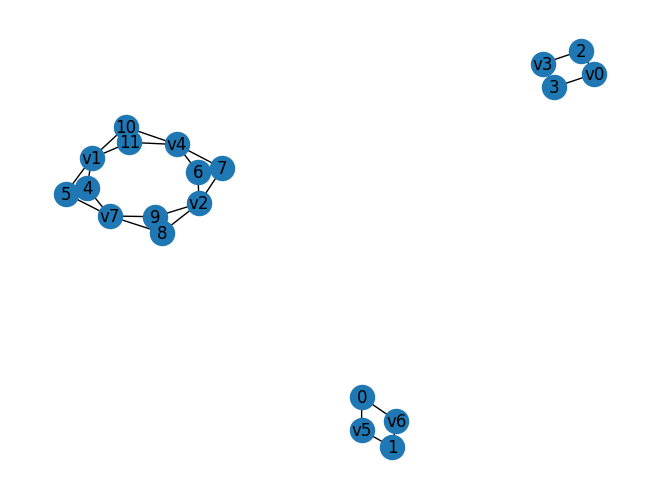

In [6]:
tree_0 = spanning_tree.copy()
tree_1 = spanning_tree.copy()

level_array = np.zeros(len(faces))


iteration_no = 1
while tree_1.number_of_nodes() >= 1:
    for node_id in list(tree_0.nodes):
        if tree_0.degree[node_id] <= 1:
            tree_1.remove_node(node_id)
            level_array[node_id] = iteration_no
    print(list(tree_0.nodes))
    print(list(tree_0.degree))
    tree_0 = tree_1.copy()
    iteration_no = iteration_no + 1

print(level_array)



facet_graph = nx.Graph()

for even_iterator in range (2, int(max(level_array))+1, 2):
    for face_id in range (len(level_array)):
        if level_array[face_id] == even_iterator:
            neighbour_faces = list(spanning_tree.adj[face_id])
            print(neighbour_faces)
            for adj_face in neighbour_faces:
                adj_neighbour_faces = list(spanning_tree.adj[adj_face])
                if level_array[adj_face] == even_iterator - 1:
                    common_vertices = np.intersect1d(faces[face_id], faces[adj_face])
                    facet_graph.add_edge(face_id, "v" + str(common_vertices[0]))
                    facet_graph.add_edge(face_id, "v" + str(common_vertices[1]))
                    facet_graph.add_edge(adj_face, "v" + str(common_vertices[0]))
                    facet_graph.add_edge(adj_face, "v" + str(common_vertices[1]))

for node in spanning_tree:
    if node not in facet_graph.nodes:
        neighbour_faces = list(spanning_tree.adj[node])
        assert len(neighbour_faces) == 1
        neighbour = neighbour_faces[0]
        assert level_array[neighbour] % 2 == 1
        common_vertices = np.intersect1d(faces[node], faces[neighbour])
        facet_graph.add_edge(node, "v" + str(common_vertices[0]))
        facet_graph.add_edge(node, "v" + str(common_vertices[1]))

nx.draw(facet_graph, with_labels = True)

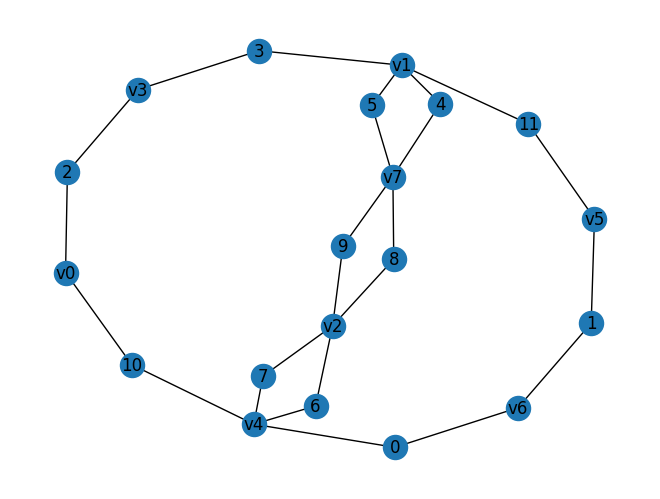

In [7]:
for face_id in range(len(faces) - 1):
    nei_nodes = list(spanning_tree.adj[face_id])
    for adj_face_id in nei_nodes:
        if (nx.has_path(facet_graph, face_id, adj_face_id)) is False:
            common_vertices = np.intersect1d(faces[face_id], faces[adj_face_id])

            if facet_graph.has_edge(face_id, "v" + str(common_vertices[0])):
                facet_graph.remove_edge(face_id, "v" + str(common_vertices[0]))
            else:
                facet_graph.add_edge(face_id, "v" + str(common_vertices[0]))
            if facet_graph.has_edge(face_id, "v" + str(common_vertices[1])):
                facet_graph.remove_edge(face_id, "v" + str(common_vertices[1]))
            else:
                facet_graph.add_edge(face_id, "v" + str(common_vertices[1]))

            if facet_graph.has_edge(adj_face_id, "v" + str(common_vertices[0])):
                facet_graph.remove_edge(adj_face_id, "v" + str(common_vertices[0]))
            else:
                facet_graph.add_edge(adj_face_id, "v" + str(common_vertices[0]))
            if facet_graph.has_edge(adj_face_id, "v" + str(common_vertices[1])):
                facet_graph.remove_edge(adj_face_id, "v" + str(common_vertices[1]))
            else:
                facet_graph.add_edge(adj_face_id, "v" + str(common_vertices[1]))

nx.draw(facet_graph, with_labels=True)

In [8]:
eulerian_circuit = list(nx.eulerian_circuit(facet_graph))
eulerian_circuit

[(3, 'v1'),
 ('v1', 4),
 (4, 'v7'),
 ('v7', 9),
 (9, 'v2'),
 ('v2', 8),
 (8, 'v7'),
 ('v7', 5),
 (5, 'v1'),
 ('v1', 11),
 (11, 'v5'),
 ('v5', 1),
 (1, 'v6'),
 ('v6', 0),
 (0, 'v4'),
 ('v4', 7),
 (7, 'v2'),
 ('v2', 6),
 (6, 'v4'),
 ('v4', 10),
 (10, 'v0'),
 ('v0', 2),
 (2, 'v3'),
 ('v3', 3)]

In [18]:
v = np.array([[0.0,0.0,0.0], [0.0,0.0,1.0], [0.0,1.0,0.0]])
f = np.array([[0,1,2], [0,1,2]])

def get_face_normal(vertices, faces, face_id):
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return face_normals[face_id]

def get_rotation_matrix(axis, angle):
    return scipy.spatial.transform.Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()

def get_2d_projection(face_normal):
    xy_plane_normal = np.array([0,0,1])  #  aka 'the z-axis'
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])
    if np.linalg.norm(rotation_axis) == 0:
        return discard_z_matrix
    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)

face_coordinates = [v[vertex_id] for vertex_id in f[0]]
for i in range(3):
    face_coordinates[i] = get_2d_projection(get_face_normal(v, f, 0)).dot(face_coordinates[i])
assert face_coordinates[0][0] == 0
assert face_coordinates[0][1] == 0
assert face_coordinates[1][0] == 1
assert face_coordinates[1][1] == 0
assert face_coordinates[2][0] == 0
assert face_coordinates[2][1] == 1

In [122]:
def tranlate_to_origin(face_coordinates):
    print("Before Translation", face_coordinates)
    min_x = face_coordinates[0][0]
    min_vector = face_coordinates[0]
    for i in range(3):
        if face_coordinates[i][0] < min_x:
            min_x = face_coordinates[i][0]
            min_vector = face_coordinates[i]
    for i in range(3):
        face_coordinates[i] = face_coordinates[i] - min_vector
    print("After Translation", face_coordinates)
    return face_coordinates

t = tranlate_to_origin([np.array([20., 18.]), np.array([-0.0, -2.]), np.array([20., -2.])]) 
assert t[0][0] == 20
assert t[0][1] == 20
assert t[1][0] == 0
assert t[1][1] == 0
assert t[2][0] == 20
assert t[2][1] == 0

Before Translation [array([20., 18.]), array([-0., -2.]), array([20., -2.])]
After Translation [array([20., 20.]), array([0., 0.]), array([20.,  0.])]


In [129]:
def rotate_triangle_to_line(face_coordinates, common_vertex1, common_vertex2):
    c1 = abs(face_coordinates[common_vertex1][1] - face_coordinates[common_vertex2][1])
    c2 = abs(face_coordinates[common_vertex1][0] - face_coordinates[common_vertex2][0])
    if c2 != 0:
        rotation_matrix = get_rotation_matrix(np.array([0., 0., 1.]), - math.atan(c1/c2))
        # print(math.degrees(math.atan(c1/c2)))
        discard_z_matrix = np.array([
            [1, 0, 0],
            [0, 1, 0]
        ])
        for i in range(3):
            face_coordinates[i] = np.delete(discard_z_matrix.dot(rotation_matrix), 2, 1).dot(face_coordinates[i])
    else:
        for i in range(3):
            face_coordinates[i] = np.array([
                    [0, -1],
                    [1, 0]
                ]).dot(face_coordinates[i])

    if face_coordinates[common_vertex1][0] > face_coordinates[common_vertex2][0]:
        for i in range(3):
            face_coordinates[i] = np.array([
                    [-1, 0],
                    [0, -1]
                ]).dot(face_coordinates[i])

    return face_coordinates

r = rotate_triangle_to_line([np.array([.0, .0]), np.array([1.0, .0]), np.array([1, 1])] , 2, 0) 
r

[array([0., 0.]),
 array([-0.70710678,  0.70710678]),
 array([-1.41421356e+00,  1.11022302e-16])]

Before Translation [array([ 18., -20.]), array([-2.00000000e+00,  3.33066907e-15]), array([ -2., -20.])]
After Translation [array([ 20., -20.]), array([0., 0.]), array([  0., -20.])]
[array([ 20., -20.]), array([0., 0.]), array([  0., -20.])]
[ 20. -20.]
Before Translation [array([-16.26345597,  -9.19238816]), array([ -2.12132034, -23.33452378]), array([12.02081528, -9.19238816])]
After Translation [array([0., 0.]), array([ 14.14213562, -14.14213562]), array([ 2.82842712e+01, -1.77635684e-15])]
[array([ 20., -20.]), array([ 34.14213562, -34.14213562]), array([ 48.28427125, -20.        ])]
[ 48.28427125 -20.        ]
Before Translation [array([10.60660172, 17.67766953]), array([ 10.60660172, -10.60660172]), array([24.74873734,  3.53553391])]
After Translation [array([1.77635684e-15, 2.82842712e+01]), array([0., 0.]), array([14.14213562, 14.14213562])]
[array([48.28427125,  8.28427125]), array([ 48.28427125, -20.        ]), array([62.42640687, -5.85786438])]
[48.28427125  8.28427125]
Bef

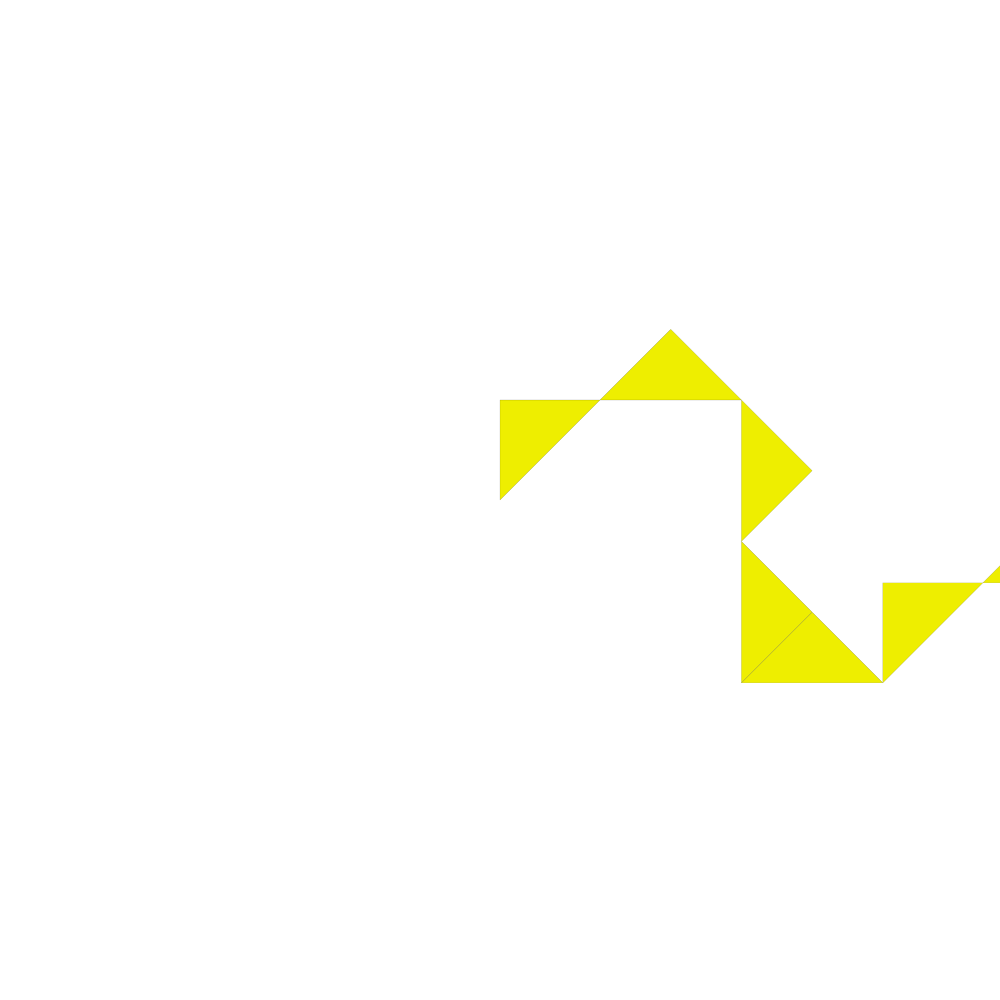

In [130]:
polygons = []
offsets = []
x_offset = 0
y_offset = 0

face_order = []
vertex_order = []

for first, second in eulerian_circuit:
    if "v" not in str(first):
        face_order.append(first)
    else:
        vertex_order.append(int(first[1:]))

for n, face_index in enumerate(face_order):
    face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_index]]
    for i in range(3):
        face_coordinates[i] = get_2d_projection(get_face_normal(vertices, faces, face_index)).dot(face_coordinates[i])
    v1 = None
    v2 = None
    for i, vertex_index in enumerate(faces[face_index]):
        if vertex_index == vertex_order[n]:
            v1 = i
        if vertex_index == vertex_order[len(vertex_order) - 1 if n - 1 < 0 else n - 1]:
            v2 = i
    polygons.append(tranlate_to_origin(rotate_triangle_to_line(face_coordinates, v1, v2)))
    for i in range(3):
        face_coordinates[i] = face_coordinates[i] + np.array([x_offset, y_offset])
    print(face_coordinates)
    x_offset = face_coordinates[v2][0]
    y_offset = face_coordinates[v2][1]
    offsets.append([x_offset, y_offset])
    print(np.array([x_offset, y_offset]))
        

drawing = draw.Drawing(1000, 1000, origin='center')
for polygon in polygons:
    # polygon = [coords[0:2] for coords in polygon]
    drawing.append(draw.Lines(*np.array(polygon).flatten()*5,
                   close=True, fill='#eeee00', stroke='#000', stroke_width=.1))


drawing.rasterize()
drawing
